In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.utils import load_img, img_to_array

# Enable mixed precision training for performance boost
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

# Upload Kaggle API key
files.upload()

# Set up Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download Chest X-ray Pneumonia dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --unzip -p /content/dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:44<00:00, 24.1MB/s]
100% 2.29G/2.29G [01:44<00:00, 23.6MB/s]


In [ ]:
# Set up dataset paths
base_dir = "/content/dataset/chest_xray/chest_xray"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Data Augmentation & Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=20, width_shift_range=0.2,
    height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary'
)
val_generator = test_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='binary'
)

# Define Spatial Transformer Network (STN)
class STN(layers.Layer):
    def __init__(self):
        super(STN, self).__init__()

    def build(self, input_shape):
        self.localization = keras.Sequential([
            layers.Conv2D(8, (7, 7), activation='relu', input_shape=input_shape[1:]),
            layers.MaxPooling2D(2, 2),
            layers.Conv2D(10, (5, 5), activation='relu'),
            layers.MaxPooling2D(2, 2),
            layers.Flatten(),
            layers.Dense(32, activation='relu'),
            layers.Dense(6, activation='linear', kernel_initializer='zeros')
        ])

    def call(self, x):
        theta = self.localization(x)
        theta = tf.reshape(theta, (-1, 2, 3))
        return tf.keras.layers.Resizing(224, 224)(x)

# Define DenseNet-121 Model with STN
base_model = keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers

# Unfreeze last 10 layers for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Build Model
inputs = keras.Input(shape=(224, 224, 3))
x = STN()(inputs)  # Apply STN
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1, activation='sigmoid')(x)  # Binary classification (Pneumonia vs Normal)
model = keras.Model(inputs, x)

# Compile Model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train Model with Checkpointing
checkpoint = keras.callbacks.ModelCheckpoint("pneumonia_densenet.keras", save_best_only=True) # Changed the file extension to .keras

history = model.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[checkpoint])

# Evaluate Model
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_acc:.4f}")


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['stn_1/sequential_1/conv2d_2/kernel', 'stn_1/sequential_1/conv2d_2/bias', 'stn_1/sequential_1/conv2d_3/kernel', 'stn_1/sequential_1/conv2d_3/bias', 'stn_1/sequential_1/dense_5/kernel', 'stn_1/sequential_1/dense_5/bias', 'stn_1/sequential_1/dense_6/kernel', 'stn_1/sequential_1/dense_6/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


163/163 ━━━━━━━━━━━━━━━━━━━━ 161s 785ms/step - accuracy: 0.7672 - loss: 0.4900 - val_accuracy: 0.7500 - val_loss: 0.3787
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 634ms/step - accuracy: 0.9037 - loss: 0.2375 - val_accuracy: 0.8125 - val_loss: 0.3624
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 650ms/step - accuracy: 0.9371 - loss: 0.1666 - val_accuracy: 0.8125 - val_loss: 0.3104
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 651ms/step - accuracy: 0.9412 - loss: 0.1455 - val_accuracy: 0.8750 - val_loss: 0.2311
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 638ms/step - accuracy: 0.9512 - loss: 0.1245 - val_accuracy: 1.0000 - val_loss: 0.1132
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 651ms/step - accuracy: 0.9555 - loss: 0.1217 - val_accuracy: 1.0000 - val_loss: 0.0917
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 647ms/step - accuracy: 0.9604 - loss: 0.1077 - val_accuracy: 1.0000 - val_loss: 0.0732
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 642ms/step - accuracy: 0.9614 - loss: 0.10

20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 903ms/step


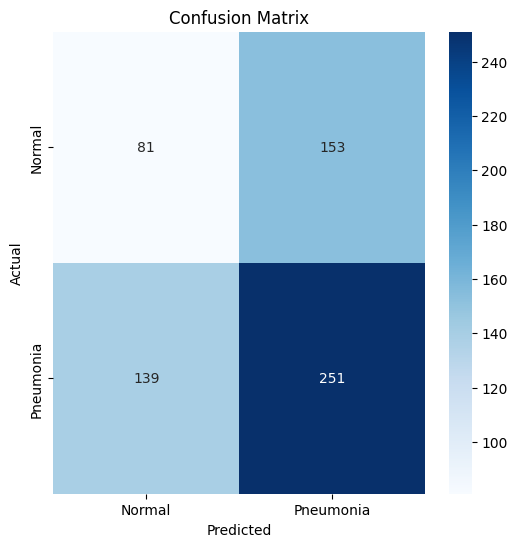


Classification Report:
              precision    recall  f1-score   support

      Normal       0.37      0.35      0.36       234
   Pneumonia       0.62      0.64      0.63       390

    accuracy                           0.53       624
   macro avg       0.49      0.49      0.49       624
weighted avg       0.53      0.53      0.53       624



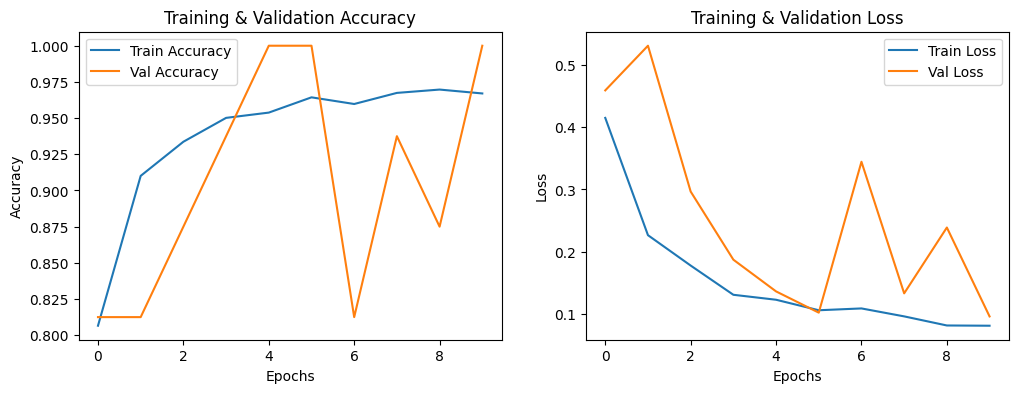

Saving person1_virus_7.jpeg to person1_virus_7.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
Prediction: Pneumonia (Confidence: 1.0000)


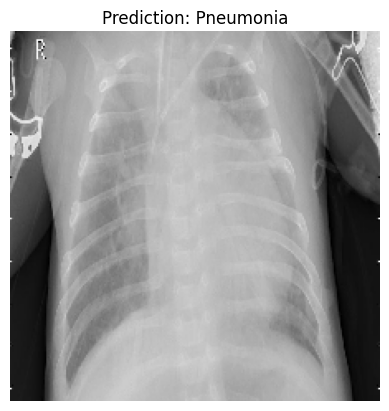

In [ ]:
# Confusion Matrix & Classification Report
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

# Training Performance Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

# Upload Image for Prediction
def predict_image():
    uploaded = files.upload()
    for file_name in uploaded.keys():
        img_path = file_name
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)[0][0]
        result = "Pneumonia" if prediction > 0.5 else "Normal"
        print(f"Prediction: {result} (Confidence: {prediction:.4f})")

        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prediction: {result}")
        plt.show()

# Call function to upload and predict
predict_image()


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:11<00:00, 59.1MB/s]
100% 2.29G/2.29G [00:11<00:00, 211MB/s] 
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 160s 690ms/step - accuracy: 0.6432 - loss: 0.0864 - val_accuracy: 0.8125 - val_loss: 0.0549 - learning_rate: 1.0000e-04
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 593ms/step - accuracy: 0.8611 - loss: 0.0381 - val_accuracy: 0.8125 - val_loss: 0.0537 - learning_rate: 1.0000e-04
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 590ms/step - accuracy: 0.9024 - loss: 0.0278 - val_accuracy: 0.8125 - val_loss: 0.0392 - learning_rate: 1.0000e-04
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 588ms/step - accuracy: 0.9197 - loss: 0.0211 - val_accuracy: 0.8125 - val_loss: 0.0360 - learning_rate: 1.0000e-04
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 589ms/step - accuracy: 0.9249 - loss: 0.0180 - val_accuracy: 0.8750 - val_loss: 0.0211 - learning_rate: 1.0000e-04
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 584ms/step - accuracy: 0.9385 - loss: 0.0164 - val_accuracy: 0.8750 - val_loss: 0.0182 - learning_rate: 1.0000e-04
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 5

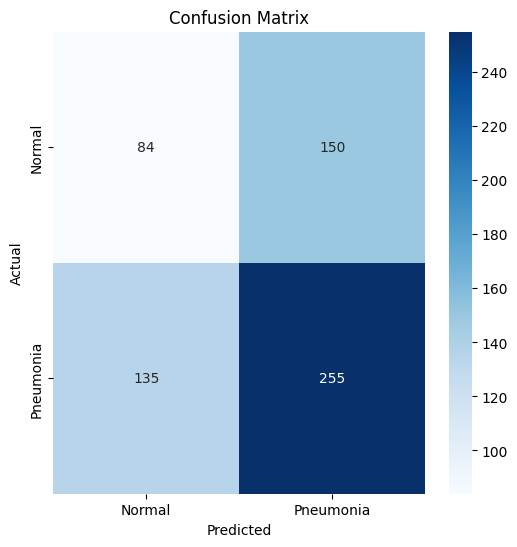


Classification Report:
              precision    recall  f1-score   support

      Normal       0.38      0.36      0.37       234
   Pneumonia       0.63      0.65      0.64       390

    accuracy                           0.54       624
   macro avg       0.51      0.51      0.51       624
weighted avg       0.54      0.54      0.54       624



In [ ]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Upload Kaggle API key
files.upload()
!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --unzip -p /content/dataset

# Dataset Paths
base_dir = "/content/dataset/chest_xray/chest_xray"
train_dir, val_dir, test_dir = [os.path.join(base_dir, x) for x in ["train", "val", "test"]]

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=30, width_shift_range=0.2,
    height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
val_generator = test_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

# Define DenseNet-121 Model
base_model = keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers

# Unfreeze last 30 layers
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Model Architecture
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, x)

# Focal Loss Function
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        loss = -y_true * alpha * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred)
        loss -= (1 - y_true) * (1 - alpha) * tf.pow(y_pred, gamma) * tf.math.log(1 - y_pred)
        return tf.reduce_mean(loss)
    return loss

# Compile Model
model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-4),
              loss=focal_loss(alpha=0.25, gamma=2.0),
              metrics=['accuracy'])

# Callbacks
checkpoint = keras.callbacks.ModelCheckpoint("pneumonia_densenet.keras", save_best_only=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train Model
history = model.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[checkpoint, lr_scheduler])

# Evaluate Model
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_acc:.4f}")

# Predictions
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

# Upload Image for Prediction
def predict_image():
    uploaded = files.upload()
    for file_name in uploaded.keys():
        img = keras.preprocessing.image.load_img(file_name, target_size=(224, 224))
        img_array = keras.preprocessing.image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Test-Time Augmentation (TTA)
        predictions = [model.predict(img_array)[0][0] for _ in range(10)]
        prediction = np.mean(predictions)
        result = "Pneumonia" if prediction > 0.5 else "Normal"

        print(f"Prediction: {result} (Confidence: {prediction:.4f})")
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prediction: {result}")
        plt.show()

predict_image()
